In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import mean_squared_error, mean_absolute_error


Certainly! Here's a point-wise introduction to the sunspot dataset that has been used in our discussions:

1. **Dataset Content:**
   - The dataset consists of monthly mean total sunspot number observations.
   - The observations span the time period from 1749 to 2023.
   - A value of -1 indicates that no number is available (missing value).

2. **Columns:**
   - **'year', 'month':** Represent the Gregorian calendar date of each observation.
   - **'frac_date':** Represents the date in the fraction of the year for the middle of the corresponding month.
   - **'mean_spots':** Indicates the monthly mean total sunspot number.
   - **'mean_std':** Represents the monthly mean standard deviation of the input sunspot numbers from individual stations.
   - **'observations':** Provides the number of observations used to compute the monthly mean total sunspot number.
   - **'definitive':** Marks whether the value is definitive (blank) or provisional ('*').

3. **Temporal Range:**
   - The dataset covers a substantial temporal range, allowing for the exploration of long-term trends and patterns in sunspot activity.

4. **Observation Characteristics:**
   - Sunspot observations include both the mean total sunspot number and associated standard deviation, providing insights into the variability of sunspot activity.

5. **Data Quality Indicators:**
   - The 'observations' column indicates the number of individual observations used to compute the monthly mean, offering insights into data reliability.
   - The 'definitive' column distinguishes between definitive and provisional values, providing information about the data's accuracy and potential for revisions.

6. **Time Series Nature:**
   - The dataset is inherently a time series, making it suitable for time series analysis and forecasting techniques.

7. **Application Areas:**
   - Sunspot data is crucial in solar physics and has applications in studying solar cycles, space weather, and their impact on Earth's climate.

8. **Dataset Purpose:**
   - The dataset facilitates the exploration of patterns, trends, and variability in sunspot activity over a significant historical period.

9. **Data Exploration Goals:**
   - Time series analysis techniques, such as smoothing and forecasting, can be applied to uncover patterns and make predictions based on the sunspot data.

10. **Research and Educational Value:**
    - The dataset is valuable for researchers and educators interested in solar physics, climatology, and time series analysis.

This sunspot dataset serves as a rich source for exploring and understanding the dynamics of solar activity over an extensive period, making it applicable in various scientific and analytical contexts.

In [2]:
cols = ["year", "month", "frac_date", "mean_spots", "mean_std", "observations", "definitive"]
data = pd.read_csv("SN_m_tot_V2.0.csv", delimiter=';', names = cols,)
#data.to_csv("sunspot_data", index = False)
samp = data.copy()
data.head(10)

,year,month,frac_date,mean_spots,mean_std,observations,definitive
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
5,1749,6,1749.455,139.2,-1.0,-1,1
6,1749,7,1749.538,158.0,-1.0,-1,1
7,1749,8,1749.623,110.5,-1.0,-1,1
8,1749,9,1749.707,126.5,-1.0,-1,1
9,1749,10,1749.790,125.8,-1.0,-1,1


In [3]:
#check for missing values
data.isnull().sum()

year            0
month           0
frac_date       0
mean_spots      0
mean_std        0
observations    0
definitive      0
dtype: int64

In [4]:
#function to convert astronomical dates to daily date format
def fraction_year_to_date(fractional_year):
    # Extracting the year
    year = int(fractional_year)

    # Calculating the remaining fractional part as days
    remaining_fraction = fractional_year - year
    days_in_year = 365 + int(year % 4 == 0 and (year % 100 != 0 or year % 400 == 0))  # Account for leap year

    # Converting the fractional part to equivalent date
    total_days = int(remaining_fraction * days_in_year)
    
    # Creating a base date for the year
    base_date = datetime(year, 1, 1)
    
    # Calculating the target date
    target_date = base_date + timedelta(days=total_days)

    return target_date.strftime("%d-%m-%Y")

#an example
fractional_year = 1749.042
result_date = fraction_year_to_date(fractional_year)
print(f'The date for {fractional_year} is: {result_date}')


The date for 1749.042 is: 16-01-1749


In [5]:
dates = list(map(fraction_year_to_date, samp["frac_date"]))
#samp.insert(3,"dates",dates)
samp.head()
samp.shape

(3300, 8)

In [6]:
print(samp.columns)
#samp.to_csv("sunspot_data", index = False)
samp.drop(columns=['mean_std','observations', 'definitive'], inplace=True)
samp.describe()

Index(['year', 'month', 'frac_date', 'dates', 'mean_spots', 'mean_std',
       'observations', 'definitive'],
      dtype='object')


,year,month,frac_date,mean_spots
count,3300.000000,3300.000000,3300.000000,3300.000000
mean,1886.000000,6.500000,1886.497992,81.773333
std,79.397168,3.452576,79.397664,67.666304
min,1749.000000,1.000000,1749.042000,0.000000
25%,1817.000000,3.750000,1817.769250,24.100000
50%,1886.000000,6.500000,1886.496500,67.550000
75%,1955.000000,9.250000,1955.225000,122.400000
max,2023.000000,12.000000,2023.958000,398.200000


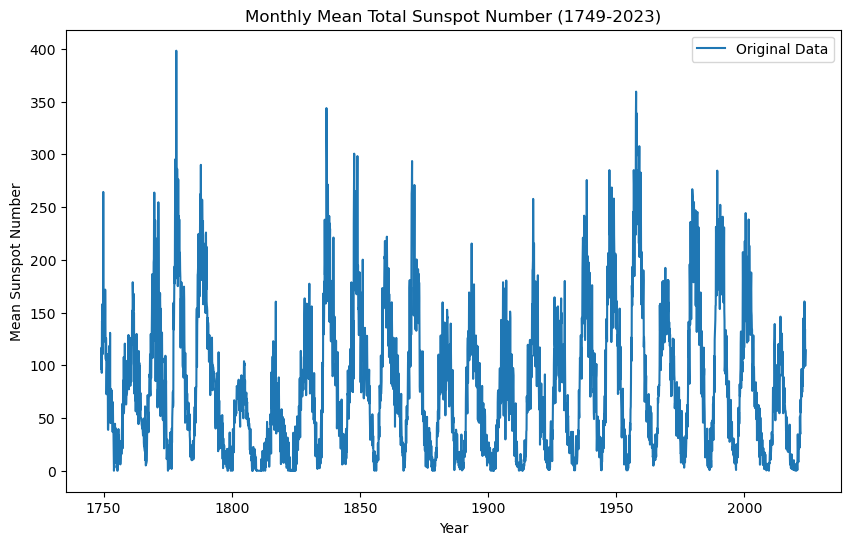

In [7]:
# Plot the original time series
plt.figure(figsize=(10, 6))
plt.plot(samp['frac_date'], samp['mean_spots'], label='Original Data')
plt.title('Monthly Mean Total Sunspot Number (1749-2023)')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Number')
plt.legend()
plt.show()


When using min_periods=1, as in your example, it means that even if there's only one observation within the window, the result will be calculated. If there are fewer than min_periods non-null data points within the window, the result is marked as NaN.

you can set min_periods to 0. The min_periods parameter in the rolling function determines the minimum number of observations required for the respective window to have a non-null result.

Setting min_periods=0 would mean that the rolling calculations will be performed even if there are zero non-null observations within the window. This can be useful if you want the rolling calculations to be performed regardless of the number of observations, even if there are missing or null values.

Keep in mind that setting min_periods to 0 might lead to more NaN values in the result, especially if there are missing or null values in the data.


In [8]:
window_size = 12 
samp['MA'] = samp['mean_spots'].rolling(window=window_size, min_periods=1).mean()
samp.head(10)

,year,month,frac_date,dates,mean_spots,MA
0,1749,1,1749.042,16-01-1749,96.7,96.700000
1,1749,2,1749.123,14-02-1749,104.3,100.500000
2,1749,3,1749.204,16-03-1749,116.7,105.900000
3,1749,4,1749.288,16-04-1749,92.8,102.625000
4,1749,5,1749.371,16-05-1749,141.7,110.440000
5,1749,6,1749.455,16-06-1749,139.2,115.233333
6,1749,7,1749.538,16-07-1749,158.0,121.342857
7,1749,8,1749.623,16-08-1749,110.5,119.987500
8,1749,9,1749.707,16-09-1749,126.5,120.711111
9,1749,10,1749.790,16-10-1749,125.8,121.220000


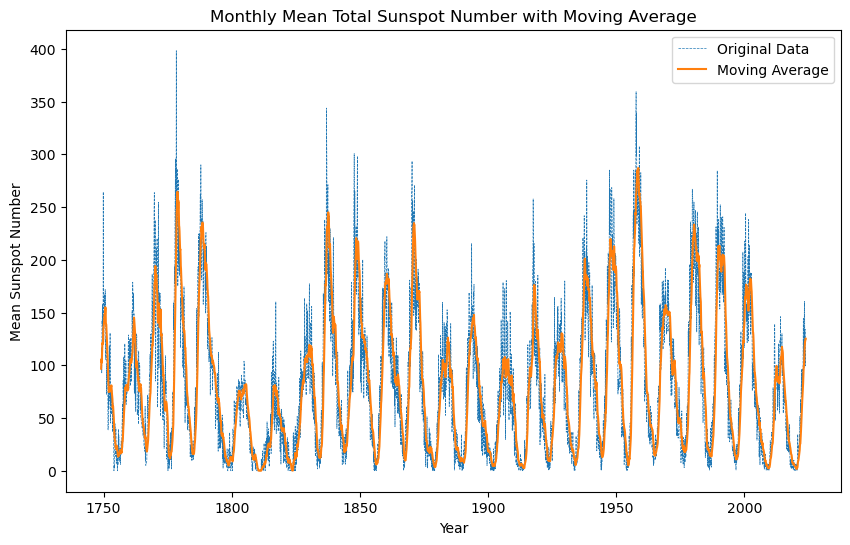

In [9]:
# Plot Moving Average
plt.figure(figsize=(10,6))
plt.plot(samp['frac_date'], samp['mean_spots'], label='Original Data', ls = "--", lw = 0.5)
plt.plot(samp['frac_date'], samp['MA'], label='Moving Average')
plt.title('Monthly Mean Total Sunspot Number with Moving Average')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Number')
plt.legend()
plt.show()

In [10]:
alpha = 0.2  # Smoothing parameter, you can adjust as needed
model_exp = ExponentialSmoothing(samp['mean_spots'], trend='add', seasonal=None)
result_exp = model_exp.fit(smoothing_level=alpha)

samp['Exp_Smooth'] = result_exp.fittedvalues
samp.head(10)



,year,month,frac_date,dates,mean_spots,MA,Exp_Smooth
0,1749,1,1749.042,16-01-1749,96.7,96.700000,117.546154
1,1749,2,1749.123,14-02-1749,104.3,100.500000,116.938971
2,1749,3,1749.204,16-03-1749,116.7,105.900000,117.595433
3,1749,4,1749.288,16-04-1749,92.8,102.625000,120.573837
4,1749,5,1749.371,16-05-1749,141.7,110.440000,117.346371
5,1749,6,1749.455,16-06-1749,139.2,115.233333,125.272354
6,1749,7,1749.538,16-07-1749,158.0,121.342857,131.529452
7,1749,8,1749.623,16-08-1749,110.5,119.987500,141.086364
8,1749,9,1749.707,16-09-1749,126.5,120.711111,138.317634
9,1749,10,1749.790,16-10-1749,125.8,121.220000,138.949409


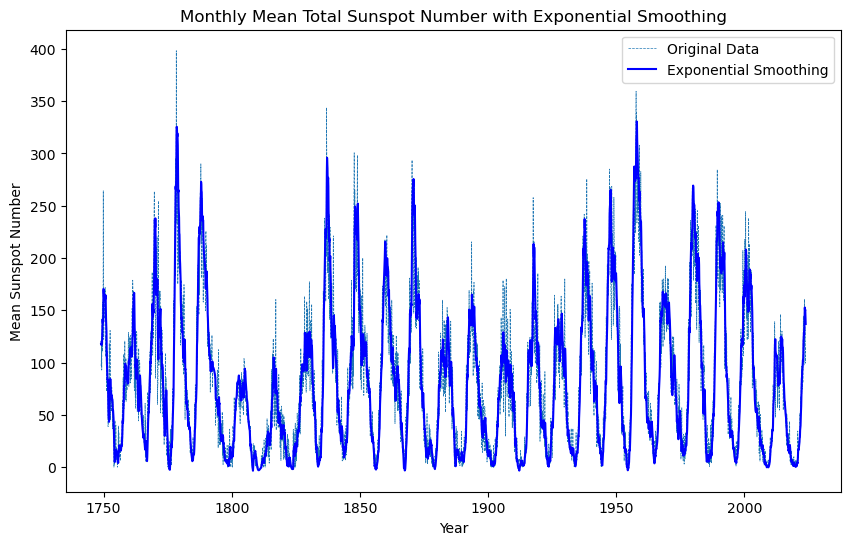

In [31]:
# Plot Exponential Smoothing
plt.figure(figsize=(10, 6))
plt.plot(samp['frac_date'], samp['mean_spots'], label='Original Data', ls = "--", lw = 0.5)
plt.plot(samp['frac_date'], samp['Exp_Smooth'], label='Exponential Smoothing', color = "blue")
plt.title('Monthly Mean Total Sunspot Number with Exponential Smoothing')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Number')
plt.legend()
plt.show()

In [36]:
#(Holt Linear Trend):
alpha = 0.2  # Smoothing parameter for level
beta = 0.2   # Smoothing parameter for trend

model_double_exp = ExponentialSmoothing(samp['mean_spots'], trend='add', seasonal=None)
result_double_exp = model_double_exp.fit(smoothing_level=alpha, smoothing_trend=beta)
samp['Double_Exp_Smooth'] = result_double_exp.fittedvalues

samp.head(10)

,year,month,frac_date,dates,mean_spots,MA,Exp_Smooth,Double_Exp_Smooth
0,1749,1,1749.042,16-01-1749,96.7,96.700000,117.546154,111.897641
1,1749,2,1749.123,14-02-1749,104.3,100.500000,116.938971,114.367185
2,1749,3,1749.204,16-03-1749,116.7,105.900000,117.595433,117.460134
3,1749,4,1749.288,16-04-1749,92.8,102.625000,120.573837,122.384087
4,1749,5,1749.371,16-05-1749,141.7,110.440000,117.346371,120.359886
5,1749,6,1749.455,16-06-1749,139.2,115.233333,125.272354,129.374130
6,1749,7,1749.538,16-07-1749,158.0,121.342857,131.529452,136.478560
7,1749,8,1749.623,16-08-1749,110.5,119.987500,141.086364,146.782962
8,1749,9,1749.707,16-09-1749,126.5,120.711111,138.317634,144.075164
9,1749,10,1749.790,16-10-1749,125.8,121.220000,138.949409,144.405920


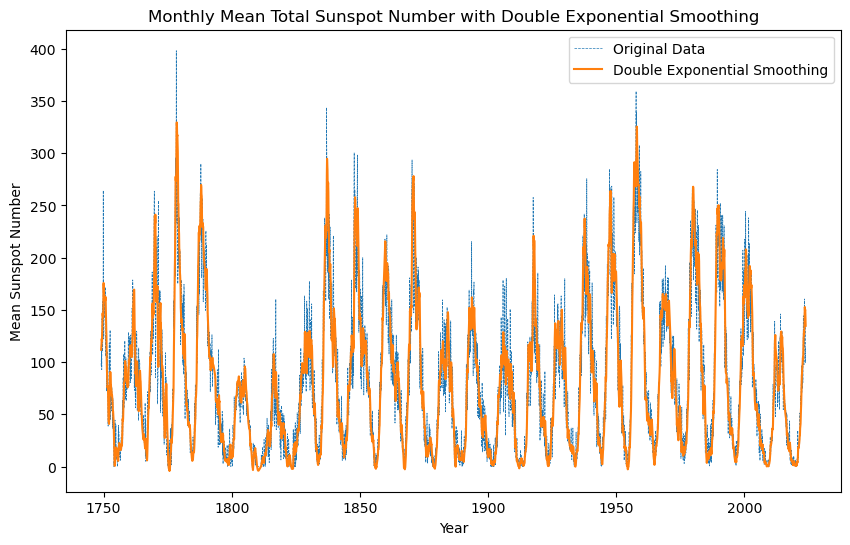

In [38]:
# Plot Double Exponential Smoothing
plt.figure(figsize=(10, 6))
plt.plot(samp['frac_date'], samp['mean_spots'], label='Original Data', ls = "--", lw = 0.5)
plt.plot(samp['frac_date'], samp['Double_Exp_Smooth'], label='Double Exponential Smoothing')
plt.title('Monthly Mean Total Sunspot Number with Double Exponential Smoothing')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Number')
plt.legend()
plt.show()

In [50]:
# Damped Trend Double Exponential Smoothing
alpha = 0.2  # Smoothing parameter for level
beta = 0.2   # Smoothing parameter for trend
phi = 0.9    # Damping factor

model_damped_trend = ExponentialSmoothing(samp['mean_spots'], trend='add', seasonal = None, damped_trend=True)
result_damped_trend = model_damped_trend.fit(smoothing_level=alpha, smoothing_trend =beta, damping_trend=phi)

samp['Damped_Trend_Exp_Smooth'] = result_damped_trend.fittedvalues
samp.head(10)

,year,month,frac_date,dates,mean_spots,MA,Exp_Smooth,Double_Exp_Smooth,Triple_Exp_Smooth,Damped_Trend_Exp_Smooth
0,1749,1,1749.042,16-01-1749,96.7,96.700000,117.546154,111.897641,101.029144,96.308636
1,1749,2,1749.123,14-02-1749,104.3,100.500000,116.938971,114.367185,102.782768,105.814009
2,1749,3,1749.204,16-03-1749,116.7,105.900000,117.595433,117.460134,119.470434,113.941093
3,1749,4,1749.288,16-04-1749,92.8,102.625000,120.573837,122.384087,119.282088,122.179093
4,1749,5,1749.371,16-05-1749,141.7,110.440000,117.346371,120.359886,130.802136,122.163223
5,1749,6,1749.455,16-06-1749,139.2,115.233333,125.272354,129.374130,133.451421,132.047857
6,1749,7,1749.538,16-07-1749,158.0,121.342857,131.529452,136.478560,149.657464,139.115313
7,1749,8,1749.623,16-08-1749,110.5,119.987500,141.086364,146.782962,144.872941,148.645424
8,1749,9,1749.707,16-09-1749,126.5,120.711111,138.317634,144.075164,132.374416,144.820960
9,1749,10,1749.790,16-10-1749,125.8,121.220000,138.949409,144.405920,128.027315,143.921372


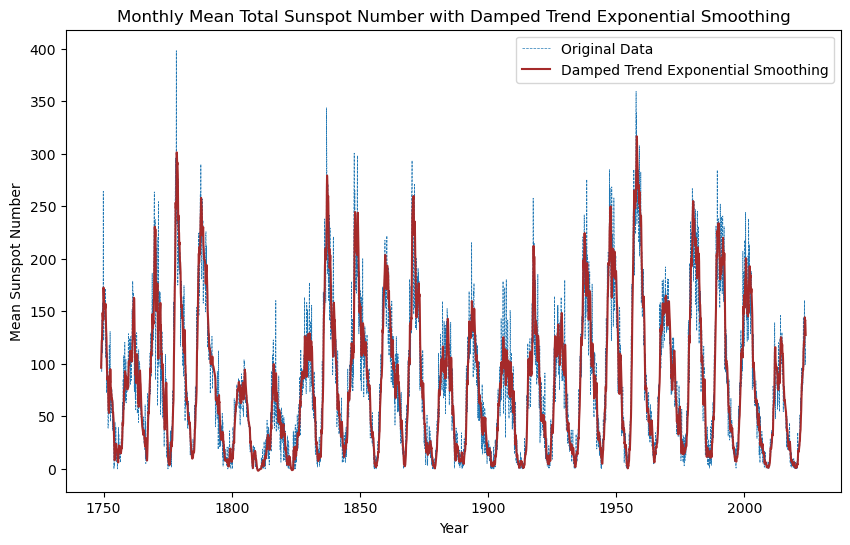

In [56]:
# Plot Damped Trend Double Exponential Smoothing
plt.figure(figsize=(10, 6))
plt.plot(samp['frac_date'], samp['mean_spots'], label='Original Data', ls = "--", lw = 0.5)
plt.plot(samp['frac_date'], samp['Damped_Trend_Exp_Smooth'], label='Damped Trend Exponential Smoothing', color = "brown")
plt.title('Monthly Mean Total Sunspot Number with Damped Trend Exponential Smoothing')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Number')
plt.legend()
plt.show()


Damping Trend Explanation:

Damping the trend is useful in situations where a trend in the time series might be strong in the short term but is expected to diminish in impact over the long term. Without damping, the trend could lead to overly optimistic or pessimistic forecasts, especially when projecting far into the future.

Damping the trend allows the model to be more conservative in extrapolating the trend, recognizing that trends may not continue indefinitely. It is a way to introduce a level of caution and realism into the forecasting process, preventing the forecast from becoming overly influenced by short-term trends that may not persist over a more extended time horizon.

In summary, the damping factor is a tool to balance the short-term influence of the trend with a more realistic long-term outlook in time series forecasting. The optimal value depends on the specific characteristics of the data and the forecasting requirements.

In [40]:
alpha = 0.2  # Smoothing parameter for level
beta = 0.2   # Smoothing parameter for trend
gamma = 0.2  # Smoothing parameter for seasonality

seasonal_periods = 12  # Assuming a yearly seasonality, can adjust as needed

model_triple_exp = ExponentialSmoothing(samp['mean_spots'], trend='add', seasonal='add', seasonal_periods=seasonal_periods)
result_triple_exp = model_triple_exp.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

samp['Triple_Exp_Smooth'] = result_triple_exp.fittedvalues
samp.head(10)


,year,month,frac_date,dates,mean_spots,MA,Exp_Smooth,Double_Exp_Smooth,Triple_Exp_Smooth
0,1749,1,1749.042,16-01-1749,96.7,96.700000,117.546154,111.897641,101.029144
1,1749,2,1749.123,14-02-1749,104.3,100.500000,116.938971,114.367185,102.782768
2,1749,3,1749.204,16-03-1749,116.7,105.900000,117.595433,117.460134,119.470434
3,1749,4,1749.288,16-04-1749,92.8,102.625000,120.573837,122.384087,119.282088
4,1749,5,1749.371,16-05-1749,141.7,110.440000,117.346371,120.359886,130.802136
5,1749,6,1749.455,16-06-1749,139.2,115.233333,125.272354,129.374130,133.451421
6,1749,7,1749.538,16-07-1749,158.0,121.342857,131.529452,136.478560,149.657464
7,1749,8,1749.623,16-08-1749,110.5,119.987500,141.086364,146.782962,144.872941
8,1749,9,1749.707,16-09-1749,126.5,120.711111,138.317634,144.075164,132.374416
9,1749,10,1749.790,16-10-1749,125.8,121.220000,138.949409,144.405920,128.027315


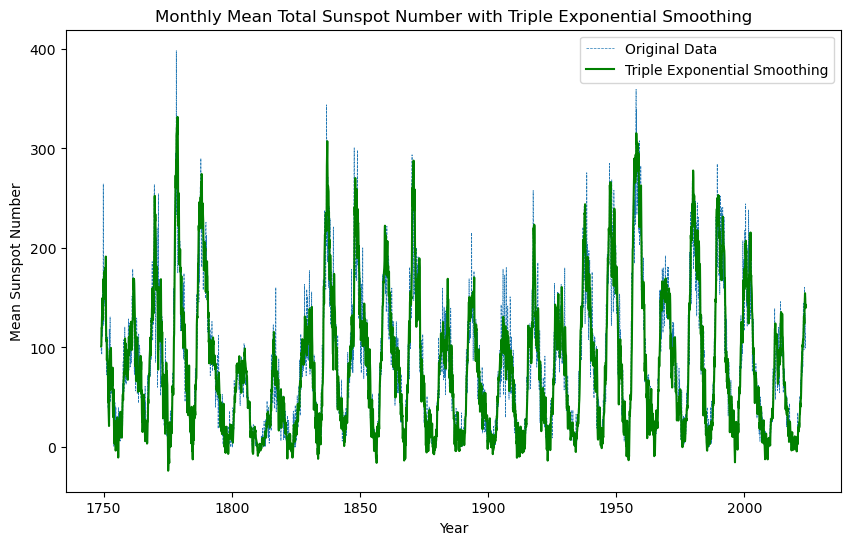

In [43]:
# Plot Triple Exponential Smoothing
plt.figure(figsize=(10, 6))
plt.plot(samp['frac_date'], samp['mean_spots'], label='Original Data', ls = "--", lw = 0.5)
plt.plot(samp['frac_date'], samp['Triple_Exp_Smooth'], label='Triple Exponential Smoothing', color = "green")
plt.title('Monthly Mean Total Sunspot Number with Triple Exponential Smoothing')
plt.xlabel('Year')
plt.ylabel('Mean Sunspot Number')
plt.legend()
plt.show()


In [55]:
# Calculate MSE and MAE for each technique
metrics = {}

# Moving Average
metrics['MA'] = {
    'MSE': mean_squared_error(samp['mean_spots'], samp['MA']),
    'MAE': mean_absolute_error(samp['mean_spots'], samp['MA'])
}

# Exponential Smoothing
metrics['Exp_Smooth'] = {
    'MSE': mean_squared_error(samp['mean_spots'], samp['Exp_Smooth']),
    'MAE': mean_absolute_error(samp['mean_spots'], samp['Exp_Smooth'])
}

# Double Exponential Smoothing
metrics['Double_Exp_Smooth'] = {
    'MSE': mean_squared_error(samp['mean_spots'], samp['Double_Exp_Smooth']),
    'MAE': mean_absolute_error(samp['mean_spots'], samp['Double_Exp_Smooth'])
}

# Calculate MSE and MAE for Damped Trend
metrics['Damped_Trend_Exp_Smooth'] = {
    'MSE': mean_squared_error(samp['mean_spots'], samp['Damped_Trend_Exp_Smooth']),
    'MAE': mean_absolute_error(samp['mean_spots'], samp['Damped_Trend_Exp_Smooth'])
}

# Triple Exponential Smoothing
metrics['Triple_Exp_Smooth'] = {
    'MSE': mean_squared_error(samp['mean_spots'], samp['Triple_Exp_Smooth']),
    'MAE': mean_absolute_error(samp['mean_spots'], samp['Triple_Exp_Smooth'])
}

# Display metrics
for technique, values in metrics.items():
    print(f"{technique} Metrics:")
    print(f"MSE: {values['MSE']}")
    print(f"MAE: {values['MAE']}")
    print("---------------------")
    

MA Metrics:
MSE: 818.8103195468314
MAE: 20.777887755258213
---------------------
Exp_Smooth Metrics:
MSE: 725.5814763001036
MAE: 19.111035798024844
---------------------
Double_Exp_Smooth Metrics:
MSE: 731.8357609683061
MAE: 19.219671262025347
---------------------
Damped_Trend_Exp_Smooth Metrics:
MSE: 690.8216445859211
MAE: 18.68501841695176
---------------------
Triple_Exp_Smooth Metrics:
MSE: 830.8887387124884
MAE: 20.90478283713496
---------------------


Single Exponential Smoothing (SES) and Double Exponential Smoothing (Holt's method) have different capabilities and are suitable for different types of time series patterns:

1. SES (Single Exponential Smoothing):
   - Suitable for data with a constant level and no clear trend or seasonality.
   - Works well when the data has a stable and consistent pattern.

2. Double Exponential Smoothing (Holt's method):
   - Incorporates a trend component in addition to level smoothing.
   - Suitable for data with a linear trend.

If the underlying time series data exhibits a stable level without a clear trend or seasonality, SES might perform well. On the other hand, if there is a noticeable linear trend in the data, Holt's method may provide better results by capturing both the level and trend components.



Here are some scenarios where double exponential smoothing might outperform triple exponential smoothing:

1. Absence of Seasonality:
   - If your time series data does not exhibit a clear and significant seasonal pattern, the additional complexity introduced by the third component (seasonality) in triple exponential smoothing may not provide significant benefits.

2. Limited Historical Data:
   - Triple exponential smoothing requires more historical data points to estimate the seasonality component accurately. If you have limited historical data, double exponential smoothing may be more robust.

3. Changing Patterns:
   - If the patterns in your time series are changing over time and the historical data may not be a good indicator of future patterns, the additional flexibility provided by triple exponential smoothing might not be beneficial.

4. Simplicity and Interpretability:
   - Double exponential smoothing is simpler and easier to interpret than triple exponential smoothing. If the interpretability of the model is important, and the additional complexity of triple exponential smoothing is not justified, then double exponential smoothing may be preferred.

However, it's crucial to note that the effectiveness of smoothing methods can vary across different datasets, and there is no one-size-fits-all solution. It's recommended to try multiple methods and select the one that provides the best performance based on validation metrics and a thorough understanding of the data patterns.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_avarage_smoothing(X,k):
    S = np.zeros(X.shape[0])
    for t in range(X.shape[0]):
        if t < k:
            S[t] = np.mean(X[:t+1])
            else:
                S[t] = np.sum(X[t-k:t])/k
                return S

def exponential_smoothing(X,α):
S = np.zeros(X.shape[0])
S[0] = X[0]
for t in range(1,X.shape[0]):
S[t] = α * X[t-1] + (1- α) * S[t-1]
return S

def double_exponential_smoothing(X,α,β):
S,A,B = (np.zeros( X.shape[0] ) for i in range(3))
S[0] = X[0]
for t in range(1,X.shape[0]):
A[t] = α * X[t] + (1- α) * S[t-1]
B[t] = β * (A[t] - A[t-1]) + (1 - β) * B[t-1]
S[t] = A[t] + B[t]
return S

def triple_exponential_smoothing(X,L,α,β,γ,ϕ):

def sig_ϕ(ϕ,m):
return np.sum(np.array([np.power(ϕ,i) for i in range(m+1)]))

C, S, B, F = (np.zeros( X.shape[0] ) for i in range(4))
S[0], F[0] = X[0], X[0]
B[0] = np.mean( X[L:2*L] - X[:L] ) / L
m = 12
sig_ϕ = sig_ϕ(ϕ,m)
for t in range(1, X.shape[0]):
S[t] = α * (X[t] - C[t % L]) + (1 - α) * (S[t-1] + ϕ * B[t-1])
B[t] = β * (S[t] - S[t-1]) + (1-β) * ϕ * B[t-1]
C[t % L] = γ * (X[t] - S[t]) + (1 - γ) * C[t % L]
F[t] = S[t] + sig_ϕ * B[t] + C[t % L]
return S

#dataset loading
AAPL = pd.read_excel('sunspot_data.xlxs')

#smoothing techiniques
time_series = np.array(AAPL['High'])[5400:]
m_a_s = moving_avarage_smoothing(time_series,12)
e_s = exponential_smoothing(time_series,0.3)
d_e_s = double_exponential_smoothing(time_series,0.5,0.1)
t_e_s = triple_exponential_smoothing(time_series,12,0.1,0.1,0.1,0.5)

#data plots
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax = plt.gca()
ax.set_facecolor('#dddddd')

plt.title('Apple Inc. Dec 12, 1980 - May 24, 2020')
plt.xlabel("> ---- Time ---- >")
plt.ylabel(">---- Share Price ---->")

plt.plot(time_series,linewidth = 2,label="Actual",color='white')
plt.plot(e_s,linewidth=1,label="exponential_smoothing",color="#88CCEE")
plt.plot(m_a_s,linewidth=1,label="moving_avarage_smoothing",color="#44AA99")
plt.plot(d_e_s,linewidth=1,label="double_exponential_smoothing",color="#117733")
plt.plot(t_e_s,linewidth=1,label="triple_exponential_smoothing",color="red")

plt.legend(fontsize=9)
plt.show()
